<a href="https://colab.research.google.com/github/Sak724/CSE437_Lab-Reports/blob/main/lab3_TD_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Temporal Difference Learning

In this lab, we will practice TD Learning methods, including SARSA and Q-Learning. Both are tabular methods that work on finite MDP.

We will solve the cliff problem: https://gymnasium.farama.org/environments/toy_text/cliff_walking/#is_slippy


The following code runs in colab, if you want to see the animation, you have to run it using python locally on your computer and replacing render_mode="ansi" for render_mode="human".

Thef follwing code runs the cliff problem using a random policy.

In [17]:
import gymnasium as gym

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 5      # number of episodes to run
max_steps = 100     # safety cap

for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0

    for step in range(max_steps):
        # Random policy: sample an action uniformly
        action = env.action_space.sample()

        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    print(f"Episode {episode+1}: total reward = {total_reward}")

env.close()

Episode 1: total reward = -199
Episode 2: total reward = -1288
Episode 3: total reward = -694
Episode 4: total reward = -694
Episode 5: total reward = -892


## Exercise 1: SARSA
Implement SARSA to solve the cliff problem above. Recommendations:



1. Define your Q table, as a matrix of [number of states] x [number of actions]
2. Greedy policy: Write a function that receives a state, the Q table, and returns the best action (the one with the maximum Q value).
3. $\epsilon$-greedy: Wreite a function that chooses the greedy policy with $\epsilon$ probality, and chooses a random actions with 1-$\epsilon$ probability.
4. Implement the SARSA algorithm based on the pseudo-code



In [33]:
import gymnasium as gym
import numpy as np

env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 1000
max_steps = 100

learning_rate = 0.1
discount_factor = 0.99
n_actions = env.action_space.n
n_states  = env.observation_space.n
Q = np.zeros((n_states, n_actions))

rng = np.random.default_rng(0)

def greedy_action(Q, s: int) -> int:
    return int(np.argmax(Q[s]))

def epsilon_greedy(Q, s: int, epsilon: float, n_actions: int, rng=rng) -> int:
    if rng.random() < epsilon:
        return int(rng.integers(n_actions))
    return greedy_action(Q, s)


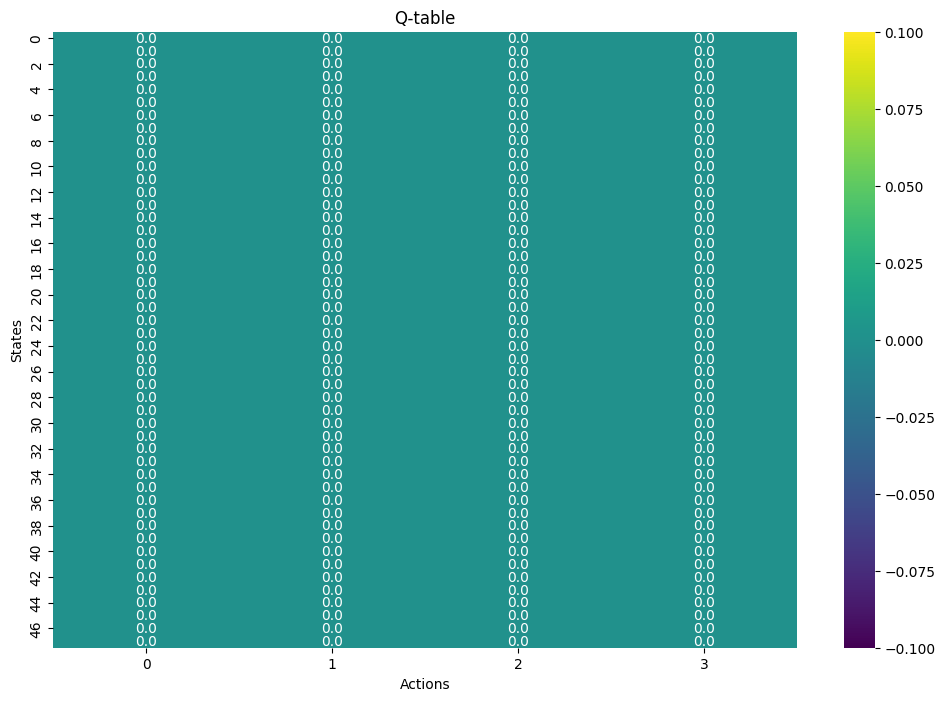

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_Q(Q):
  plt.figure(figsize=(12, 8))
  sns.heatmap(Q, annot=True, fmt=".1f", cmap="viridis")
  plt.xlabel("Actions")
  plt.ylabel("States")
  plt.title("Q-table")
  plt.show()

plot_Q(Q)

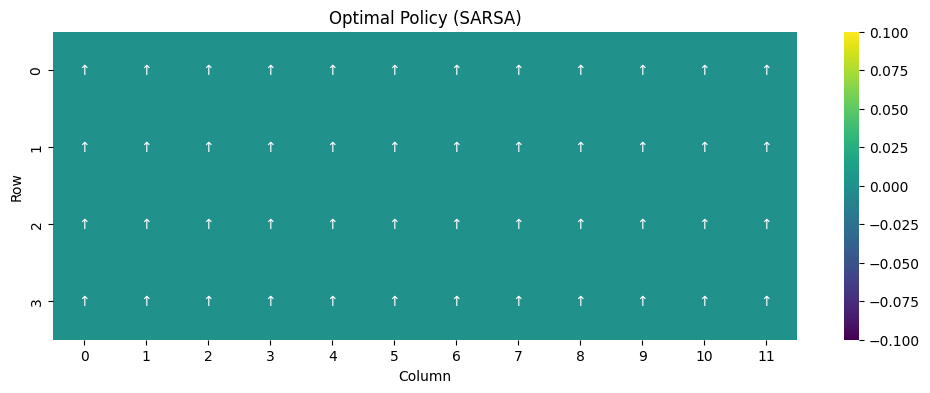

In [26]:
def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Optimal Policy (SARSA)")
  plt.show()
plot_policy(Q)

In [34]:
alpha   = 0.5      # robust for CliffWalking
gamma   = 1.0      # episodic
epsilon = 0.1
episodes = 5000
max_steps = 200

returns_sarsa = []

for ep in range(episodes):
    s, _ = env.reset()
    a = epsilon_greedy(Q, s, epsilon, n_actions, rng)
    G = 0.0

    for t in range(max_steps):
        s2, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        if not done:
            a2 = epsilon_greedy(Q, s2, epsilon, n_actions, rng)
            target = r + gamma * Q[s2, a2]
        else:
            a2 = None
            target = r

        Q[s, a] += alpha * (target - Q[s, a])
        s, a = s2, (a2 if a2 is not None else 0)
        G += r
        if done:
            break

    returns_sarsa.append(G)

print("Avg return last 100:", np.mean(returns_sarsa[-100:]))


Avg return (last 100): -23.51


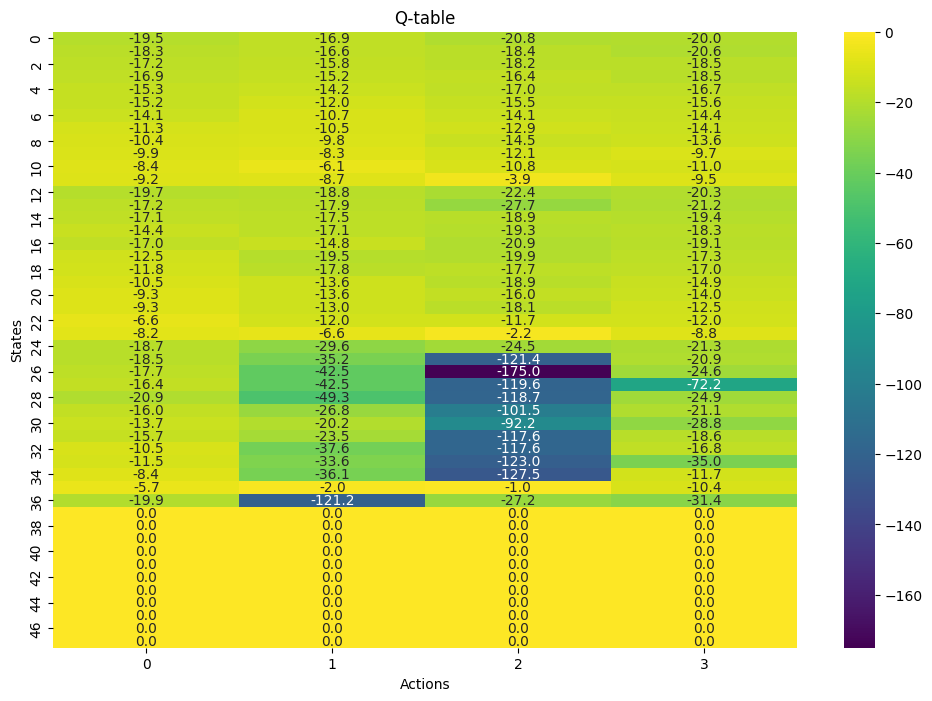

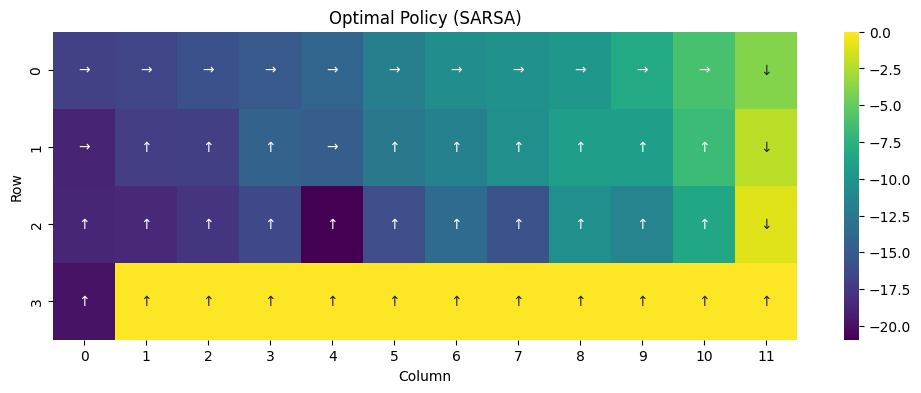

In [35]:
plot_Q(Q)
plot_policy(Q)


## Exercise 2.1: Q: Learning
Implement Q-learning method to solve the cliff problem

In [36]:
# Q-Learning training on CliffWalking
Q_ql = np.zeros((n_states, n_actions), dtype=float)

alpha   = 0.5
gamma   = 1.0
epsilon = 0.1
episodes = 5000
max_steps = 200

returns_ql = []

for ep in range(episodes):
    s, _ = env.reset()
    G = 0.0
    for t in range(max_steps):
        a = epsilon_greedy(Q_ql, s, epsilon, n_actions, rng)
        s2, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        best_next = 0.0 if done else np.max(Q_ql[s2])
        target = r + gamma * best_next
        Q_ql[s, a] += alpha * (target - Q_ql[s, a])
        s = s2
        G += r
        if done:
            break
    returns_ql.append(G)

print("Q-Learning avg return (last 100):", np.mean(returns_ql[-100:]))


Q-Learning avg return (last 100): -45.46


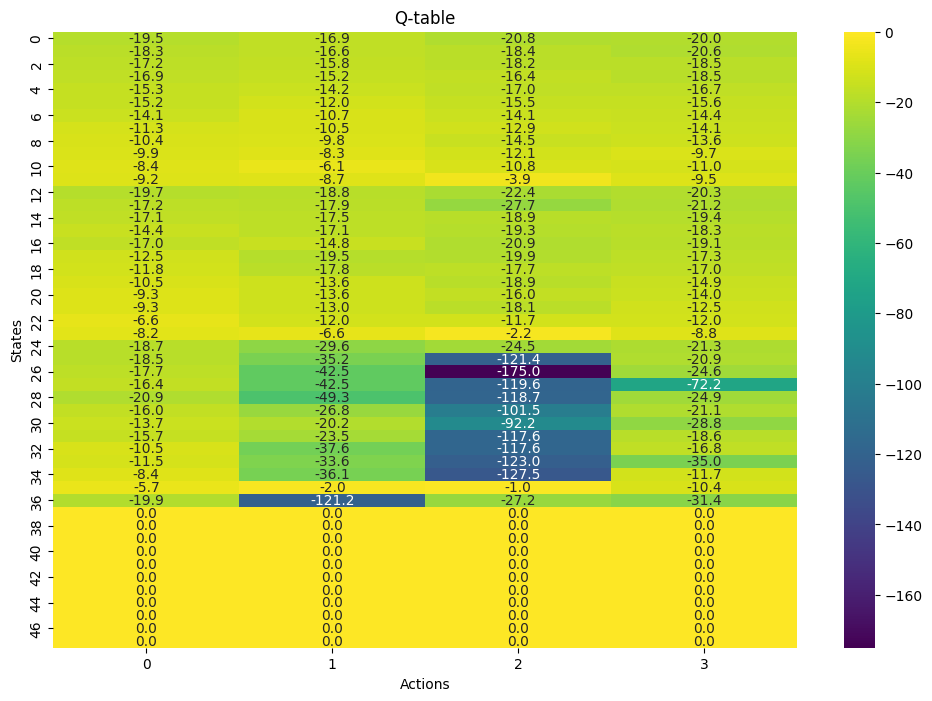

In [37]:
plot_Q(Q)

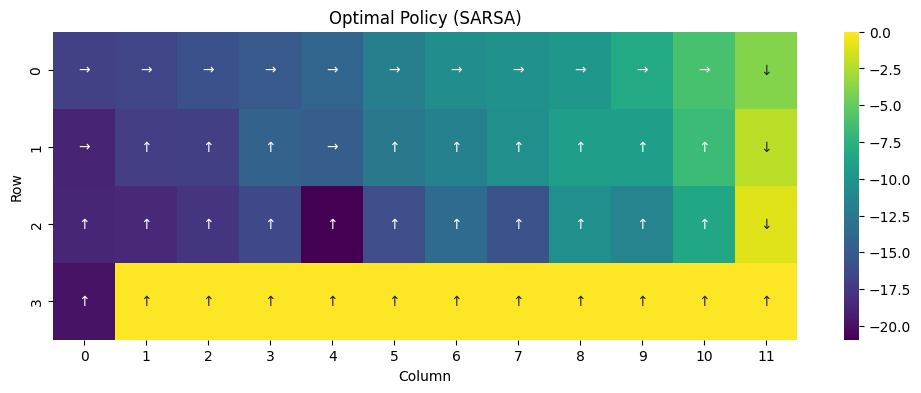

In [38]:
plot_policy(Q, "Q-Learning")

## Exercise 2.2: SARSA vs Q-learning
 1. Compare the results betwen SARSA and Q-Learning (plot a graph of the sum of rewards duing each episode for each algorithm).
 2. Include the is_slippery=True parameter. Compare again, which one is better?


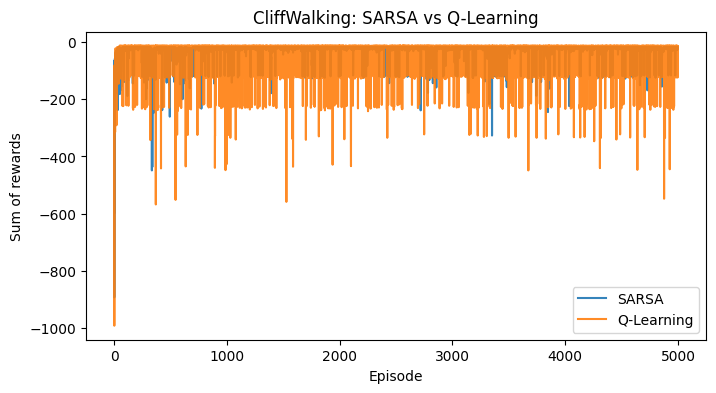

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(returns_sarsa, label="SARSA", alpha=0.9)
plt.plot(returns_ql,     label="Q-Learning", alpha=0.9)
plt.xlabel("Episode"); plt.ylabel("Sum of rewards")
plt.title("CliffWalking: SARSA vs Q-Learning")
plt.legend(); plt.show()


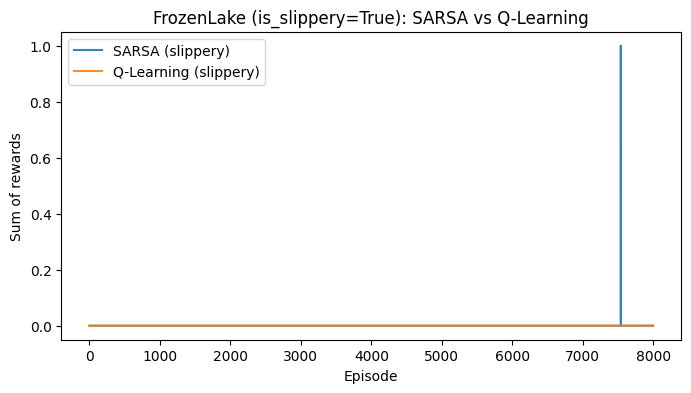

FrozenLake slippery — SARSA last-500 avg: 0.002
FrozenLake slippery — Q-Learning last-500 avg: 0.0


In [42]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

fl_env = gym.make("FrozenLake-v1", is_slippery=True)
nS_fl, nA_fl = fl_env.observation_space.n, fl_env.action_space.n

# SARSA
Q_fl_sarsa = np.zeros((nS_fl, nA_fl))
alpha, gamma, epsilon = 0.5, 0.99, 0.1
episodes, max_steps = 8000, 200
rng_s = np.random.default_rng(42)
ret_fl_sarsa = []

for ep in range(episodes):
    s, _ = fl_env.reset()
    a = epsilon_greedy(Q_fl_sarsa, s, epsilon, nA_fl, rng_s)
    G = 0.0
    for t in range(max_steps):
        s2, r, term, trunc, _ = fl_env.step(a)
        done = term or trunc
        if not done:
            a2 = epsilon_greedy(Q_fl_sarsa, s2, epsilon, nA_fl, rng_s)
            target = r + gamma * Q_fl_sarsa[s2, a2]
        else:
            a2 = None
            target = r
        Q_fl_sarsa[s, a] += alpha * (target - Q_fl_sarsa[s, a])
        s, a = s2, (a2 if a2 is not None else 0)
        G += r
        if done: break
    ret_fl_sarsa.append(G)

# Q-Learning
Q_fl_ql = np.zeros((nS_fl, nA_fl))
rng_q = np.random.default_rng(43)
ret_fl_ql = []

for ep in range(episodes):
    s, _ = fl_env.reset()
    G = 0.0
    for t in range(max_steps):
        a = epsilon_greedy(Q_fl_ql, s, epsilon, nA_fl, rng_q)
        s2, r, term, trunc, _ = fl_env.step(a)
        done = term or trunc
        best_next = 0.0 if done else np.max(Q_fl_ql[s2])
        target = r + gamma * best_next
        Q_fl_ql[s, a] += alpha * (target - Q_fl_ql[s, a])
        s = s2
        G += r
        if done: break
    ret_fl_ql.append(G)

# Plot
plt.figure(figsize=(8,4))
plt.plot(ret_fl_sarsa, label="SARSA (slippery)", alpha=0.9)
plt.plot(ret_fl_ql,     label="Q-Learning (slippery)", alpha=0.9)
plt.xlabel("Episode"); plt.ylabel("Sum of rewards")
plt.title("FrozenLake (is_slippery=True): SARSA vs Q-Learning")
plt.legend(); plt.show()

print("FrozenLake slippery — SARSA last-500 avg:", np.mean(ret_fl_sarsa[-500:]))
print("FrozenLake slippery — Q-Learning last-500 avg:", np.mean(ret_fl_ql[-500:]))


# Exercise 3 (graduate students): 8x8 grid problem
Solve the 8x8 grid problem from the previous lab. You can use SARSA or Q-learning. How many episodes does it need to learn the optimal policy?


In [74]:
!pip install -q gym-simplegrid


In [85]:
import gymnasium as gym
import gym_simplegrid
import numpy as np


START_LOC = 15
GOAL_LOC  = 3
options   = {'start_loc': START_LOC, 'goal_loc': GOAL_LOC}
env = gym.make('SimpleGrid-8x8-v0', render_mode='ansi')


rng = np.random.default_rng(0)
def greedy_action(Q, s): return int(np.argmax(Q[s]))
def epsilon_greedy(Q, s, eps, nA):
    return int(rng.integers(nA)) if rng.random() < eps else greedy_action(Q, s)
def lin_decay(v0, vmin, t, T):
    return vmin + (v0 - vmin) * max(0.0, (T - t) / T)

def greedy_path_length(env, Q, options, cap=400):
    s, _ = env.reset(options=options)
    steps = 0
    for _ in range(cap):
        a = greedy_action(Q, s)
        s, r, done, _, _ = env.step(a)
        steps += 1
        if done: return steps, True
    return steps, False

# ---- Q-Learning ----
episodes  = 20000
max_steps = 200
gamma     = 1.0
alpha0, alpha_min = 0.5, 0.05
eps0,  eps_min    = 0.20, 0.01

nS = env.observation_space.n    # 64
nA = env.action_space.n         # 4 (0↑,1→,2↓,3←)
Q  = np.zeros((nS, nA), dtype=float)

best_len = None
first_opt_ep = None
stable_opt_ep = None
patience = 200
streak = 0

for ep in range(episodes):
    alpha = lin_decay(alpha0, alpha_min, ep, episodes)
    eps   = lin_decay(eps0,  eps_min,  ep, episodes)

    s, _ = env.reset(options=options)
    for _ in range(max_steps):
        a = epsilon_greedy(Q, s, eps, nA)
        s2, r, done, _, _ = env.step(a)
        Q[s, a] += alpha * ((r + (0.0 if done else gamma * np.max(Q[s2]))) - Q[s, a])
        s = s2
        if done: break

    steps, reached = greedy_path_length(env, Q, options)
    if reached:
        if (best_len is None) or (steps < best_len):
            best_len = steps
            first_opt_ep = ep + 1
            streak = 0
        else:
            streak += 1
        if (stable_opt_ep is None) and (streak >= patience):
            stable_opt_ep = ep + 1

print("Best greedy path length:", best_len)
print("First episode reaching it:", first_opt_ep)
print("Episodes to stable optimal (no improvement ~200 eps):", stable_opt_ep)


def idx_to_rc(i): return (i//8, i%8)
s, _ = env.reset(options=options)
path = [s]
for _ in range(400):
    a = greedy_action(Q, path[-1])
    s, r, done, _, _ = env.step(a)
    path.append(s)
    if done: break

print("Final greedy steps:", len(path)-1, "| reached goal:", done)
print("Path (row,col):", [idx_to_rc(p) for p in path])


Best greedy path length: 5
First episode reaching it: 8
Episodes to stable optimal (no improvement ~200 eps): 208
Final greedy steps: 5 | reached goal: True
Path (row,col): [(1, 7), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3)]
